In [1]:
"""Example of using GOSAC to optimize a function with constraints."""

# Copyright (c) 2025 Alliance for Energy Innovation, LLC

# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.

# You should have received a copy of the GNU General Public License
# along with this program.  If not, see <http://www.gnu.org/licenses/>.

__authors__ = ["Weslley S. Pereira"]
__contact__ = "weslley.dasilvapereira@nrel.gov"
__maintainer__ = "Weslley S. Pereira"
__email__ = "weslley.dasilvapereira@nrel.gov"
__credits__ = ["Juliane Mueller", "Weslley S. Pereira"]
__deprecated__ = False

# Constrained global optimization with GOSAC

In this example, we use GOSAC to solve a constrained global optimization problem. In GOSAC, it is assumed that the objective function is cheap to evaluate, and so only the constraints are modeled by surrogates. The feasible region for GOSAC is composed by the points $x$ such that $g(x) \le 0$ for every constraint $g$.

In [2]:
from soogo import gosac, RbfModel
from tests.gosac_benchmark import gosac_p

import matplotlib.pyplot as plt
import numpy as np

import logging

logging.basicConfig(level=logging.INFO)

In [3]:
def plot_2d(FX, bounds, label, x=None, y=None):
    fig, ax = plt.subplots()
    im = ax.imshow(
        FX,
        cmap="jet",
        extent=[bounds[0][0], bounds[0][1], bounds[1][1], bounds[1][0]],
    )
    fig.colorbar(im, ax=ax, label=label)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    if x is not None and y is not None:
        ax.scatter(x[0 : len(x) - 1], y[0 : len(x) - 1], c="gray", marker="x")
        ax.scatter(x[-1], y[-1], c="w", marker="x")
    return fig, ax

The model problem uses the Bird function as objective and the Rana function as the single constraint over the two-dimensional input space.

In [4]:
# problem_idx = 9  # mixed-integer optimization
problem_idx = 17  # continuous optimization
problem = gosac_p[problem_idx]

iindex = problem.iindex
bounds = problem.bounds
dim = len(bounds)
gdim = problem.gfun(np.zeros((1, dim))).shape[1]

In [5]:
# Grid for plotting
nx = 1000 if 0 not in iindex else int(bounds[0][1] - bounds[0][0] + 1)
ny = 1000 if 1 not in iindex else int(bounds[1][1] - bounds[1][0] + 1)
x = (
    np.linspace(bounds[0][0], bounds[0][1], nx)
    if 0 not in iindex
    else np.arange(bounds[0][0], bounds[0][1] + 1, 1, dtype=int)
)
y = (
    np.linspace(bounds[1][0], bounds[1][1], ny)
    if 1 not in iindex
    else np.arange(bounds[1][0], bounds[1][1] + 1, 1, dtype=int)
)
XY = np.array([[[x[j], y[i]] for j in range(nx)] for i in range(ny)])

Plotting problem 18 (gosac_p[17])


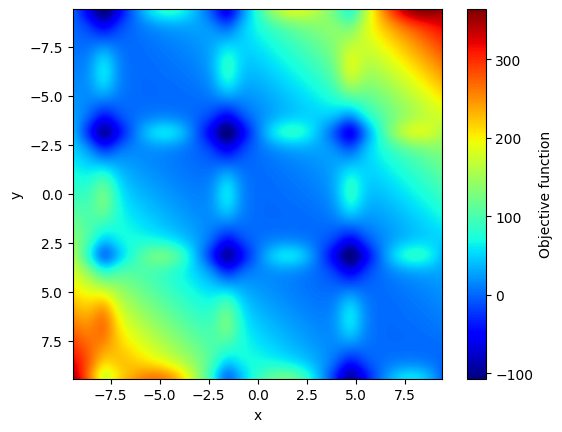

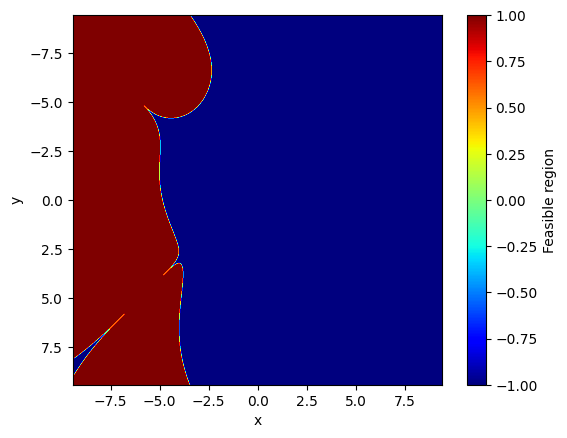

In [6]:
%matplotlib inline

print(f"Plotting problem {problem_idx + 1} (gosac_p[{problem_idx}])")

Z = np.zeros((ny, nx))
G = np.zeros((ny, nx))
for i in range(ny):
    Z[i, :] = problem.objf(XY[i, :])
    G[i, :] = np.where(np.all(problem.gfun(XY[i, :]) <= 0.0, axis=1), -1, 1)

plot_2d(Z, bounds, "Objective function")
plot_2d(G, bounds, "Feasible region")
plt.show()

Below, we run the problem and collect the final results in the variable `res`.

GOSAC has two phases. Phase 1 searches for feasible regions in the domain, and stops as soon as there is at least one feasible point. Every iteration of phase 2 performs a global optimization with the trained surrogate. Both phases update the surrogate for improved knowledge about the constraints.

In [7]:
s = RbfModel(iindex=problem.iindex)
res = gosac(
    problem.objf,
    problem.gfun,
    bounds,
    maxeval=100,
    surrogateModel=s,
    seed=3,
)

INFO:soogo.optimize.gosac:(Phase 2) Iteration: 0
INFO:soogo.optimize.gosac:fEvals: 6
INFO:soogo.optimize.gosac:Best value: 15.838026
INFO:soogo.optimize.gosac:Time to update surrogate model: 0.000520 s
INFO:soogo.optimize.gosac:Solving the cheap problem with surrogate cons: 1 points in 0.188446 s
INFO:soogo.optimize.gosac:(Phase 2) Iteration: 1
INFO:soogo.optimize.gosac:fEvals: 7
INFO:soogo.optimize.gosac:Best value: -106.764537
INFO:soogo.optimize.gosac:Time to update surrogate model: 0.000244 s
INFO:soogo.optimize.gosac:Solving the cheap problem with surrogate cons: 1 points in 0.188475 s
INFO:soogo.optimize.gosac:(Phase 2) Iteration: 2
INFO:soogo.optimize.gosac:fEvals: 8
INFO:soogo.optimize.gosac:Best value: -106.764537
INFO:soogo.optimize.gosac:Time to update surrogate model: 0.000206 s
INFO:soogo.optimize.gosac:Solving the cheap problem with surrogate cons: 1 points in 0.316028 s
INFO:soogo.optimize.gosac:(Phase 2) Iteration: 3
INFO:soogo.optimize.gosac:fEvals: 9
INFO:soogo.optimi

We repeat the plots from above and put the graph of the trained surrogate for comparison. The best solution for the optimization is the cross marked in bold.

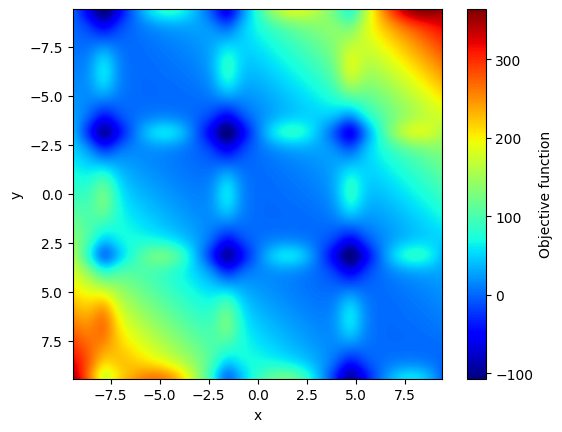

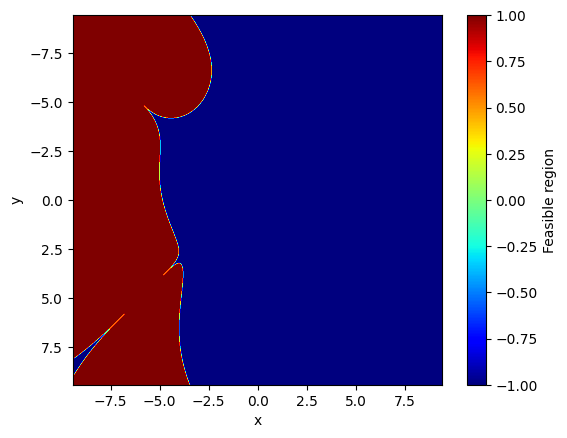

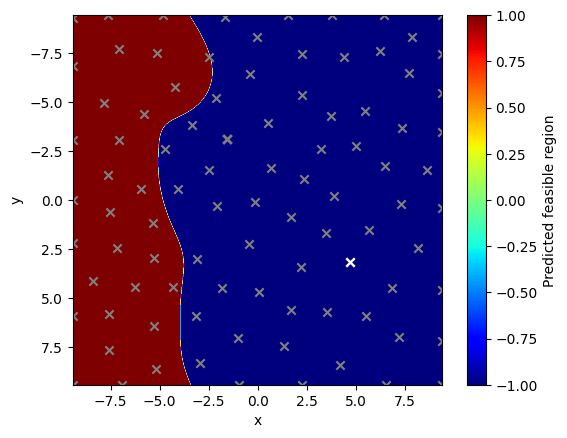

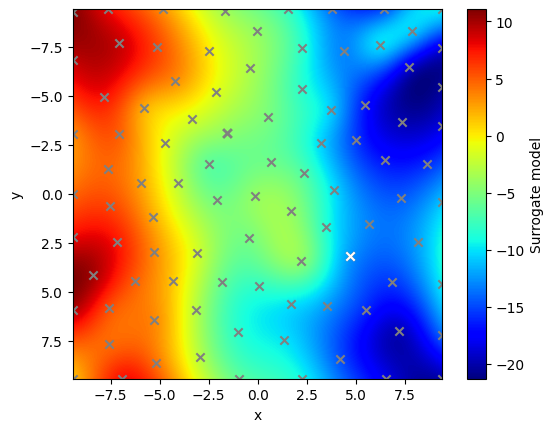

In [8]:
%matplotlib inline

S = np.zeros((ny, nx))
Sfeas = np.zeros((ny, nx))
for i in range(ny):
    aux = s(XY[i, :]).reshape((nx, -1))
    S[i, :] = aux.flatten()
    Sfeas[i, :] = np.where(np.all(aux <= 0.0, axis=1), -1, 1)

xscatter = s.X[:, 0]
xscatter = np.concatenate((xscatter, [res.x[0]]))
yscatter = s.X[:, 1]
yscatter = np.concatenate((yscatter, [res.x[1]]))

plot_2d(Z, bounds, "Objective function")
plot_2d(G, bounds, "Feasible region")
plot_2d(Sfeas, bounds, "Predicted feasible region", x=xscatter, y=yscatter)
plot_2d(S, bounds, "Surrogate model", x=xscatter, y=yscatter)
plt.show()